Group Name:  
Name: Dmitry Sharukhin  
Email: sharuhinda@gmail.com  
Country: Russia  
College/Company: Finval GC  
Specialization: Data Science  

In [2]:
import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2


In [3]:
df = pd.read_csv('datasets/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

On previous cycle of EDA there were following assumptions:  
`month` contains only 10 values (Jan and Feb are absent) with modal value 'May'. According to data description observations refer to period from May 2008 to November 2010 and ARE ORDERED BY DATE => we can try to restore month-year values based on the months order (CHECK FULL DATASET (1) for Jan and Feb values, (2) if restore data then in both datasets) + we can use months after 2008 year's financial crisis as a new feature

In [5]:
# Check what months are included
df['month'].value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

So we still have 10 months so training set contains no months bias compared to initial dataset  
The 2nd thing to do is to try to bound data to years and create new feature(s) based on [Great Recession Information](https://en.wikipedia.org/wiki/Great_Recession#:~:text=The%20combination%20of%20banks%20unable,thus%20extending%20over%2019%20months.) (the Great Recession that began in the U.S. officially in December 2007 and lasted until June 2009, thus extending over 19 month)  
We can create 2 new features `prev_month` and `year`: for record #1 their values will be 'NAN' and '2008' respectively. As all observations in the initial dataset are ordered by date then for next records feature `year` can be calculated based on:  
$$
year = \left \{ \begin{matrix}
    year+1 & \text{if\ \ } 'prevmonth' == 'dec' \ and\ 'month' == 'mar' \\
    year & \text{else}
\end{matrix}
\right.
$$

In [7]:
# finding records where year should change
df['prev_month'] = df['month'].shift(1)
df[(df['month']=='mar') & (df['prev_month']=='dec')]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,prev_month
27690,26,student,single,basic.9y,no,yes,no,cellular,mar,mon,...,999,0,nonexistent,-1.8,92.843,-50.0,1.811,5099.1,yes,dec
39130,39,admin.,single,university.degree,no,yes,no,telephone,mar,mon,...,999,1,failure,-1.8,93.369,-34.8,0.655,5008.7,yes,dec


In [8]:
# initializing year
df['year'] = 2008
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,prev_month,year
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,None,2008
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,may,2008
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,may,2008
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,may,2008
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,may,2008


In [10]:
df.loc[27690:39130, 'year'] = 2009
df.loc[39130:, 'year'] = 2010
df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,prev_month,year
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,nov,2010
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,nov,2010
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,nov,2010
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,nov,2010
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no,nov,2010


In [13]:
# check switching points
df.loc[27687:27693, ['month', 'prev_month', 'year']]

,month,prev_month,year
27687,dec,dec,2008
27688,dec,dec,2008
27689,dec,dec,2008
27690,mar,dec,2009
27691,mar,mar,2009
27692,mar,mar,2009
27693,mar,mar,2009


In [14]:
df.loc[39128:39133, ['month', 'prev_month', 'year']]

,month,prev_month,year
39128,dec,dec,2009
39129,dec,dec,2009
39130,mar,dec,2010
39131,mar,mar,2010
39132,mar,mar,2010
39133,mar,mar,2010


In [15]:
df = df.drop(columns='prev_month')

Conclusion:
1. we still have 10 months in original dataset so train set contains no months bias  
2. as our task is to predict target values for new instances that comes later than last observations in original dataset then the 'months_from_2018' feature is not useful as it doesn't contain relative info and our purpose is to extrapolate and not interpolate. In latter case new feature could be useful

We have highly imbalanced dataset where positive target values are about 11% of total observations number.  
We should use stratified split to get the train and test datasets

In [7]:
X = df.iloc[:, :-1]
y = df['y']
print(X.shape, X.columns)
print(y.shape, y.name)

(41188, 20) Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')
(41188,) y


In [11]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['y'], random_state=42)

In [15]:
print('Train dataset dimensions:', df_train.shape)
print('Test dataset dimensions:', df_test.shape)

Train dataset dimensions: (28831, 21)
Test dataset dimensions: (12357, 21)


In [17]:
print('Initial dataset target labels ratio: {:.3f}'.format(len(df[df['y']=='yes'])/len(df)))
print('Train set target labels ratio: {:.3f}'.format(len(df_train[df_train['y']=='yes'])/len(df_train)))
print('Test set target labels ratio: {:.3f}'.format(len(df_test[df_test['y']=='yes'])/len(df_test)))

Initial dataset target labels ratio: 0.113
Train set target labels ratio: 0.113
Test set target labels ratio: 0.113


In [22]:
# Visualizing splits
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [43]:
# function that visualizes the train-test split
def plot_split_indices(idxs, shift, ax, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    all_idxs = np.array([])
    for idx_list in idxs:
        all_idxs = np.concatenate((all_idxs, idx_list))
    all_idxs = np.sort(all_idxs)

    colors = np.array([np.nan]*len(all_idxs))
    for c, idx_list in enumerate(idxs):
        colors[idx_list] = c

    ax.scatter(
        range(len(all_idxs)),
        [shift] * len(all_idxs),
        c=colors,
        marker="_",
        lw=lw,
        cmap=cmap_cv,
        vmin=-0.2,
        vmax=1.2,
    )

    ax.set_title("{}".format('Split visualization'), fontsize=15)
    return ax

In [53]:
stratsplitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

<generator object <genexpr> at 0x000002CA2CCB6DC0>

In [56]:
for x in stratsplitter.split(df.iloc[:, :-1], df['y']):
    idxs_train, idxs_test = x[0], x[1]

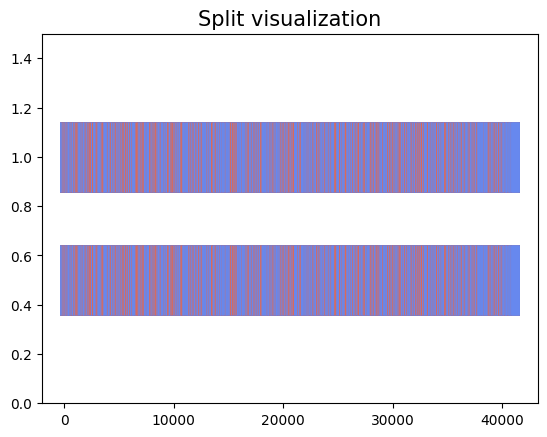

In [59]:
fig, ax = plt.subplots()
plot_split_indices([df_train.index, df_test.index], shift=0.5, ax=ax, lw=50)
plot_split_indices([idxs_train, idxs_test], shift=1.0, ax=ax, lw=50)
ax.set_ybound(lower=0, upper=1.5)

In [62]:
# Check if indices using train_test_split are the same as using StratifiedShuffleSplit 
print([x for x in df_train.index if x not in idxs_train])
print([x for x in df_test.index if x not in idxs_test])

[]
[]


So the split is the same and we can save train and test datasets in separate files

In [63]:
df_train.to_csv('datasets/bank-train.csv', index=False)
df_test.to_csv('datasets/bank-test.csv', index=False)